# Import Libraries and Constants

In [1]:
%matplotlib inline
import torch as th
#import torch.nn.functional as F
import torch.nn as nn 
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
#from sklearn.model_selection import train_test_split,  RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_poisson_deviance, d2_tweedie_score, make_scorer, auc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from skorch import NeuralNetRegressor, NeuralNet, callbacks
import utils
import architecture
import run_config

In [2]:
NUM_ROUNDS = run_config.server_config["num_rounds"]

In [3]:
FL_PATH = '../ag_-1/fl_model.pt'

In [4]:
FL_NUM_UNITS_1 = 40

In [5]:
FL_NUM_UNITS_2 = 60

In [6]:
NUM_FEATURES = run_config.model_architecture["num_features"]

# Load Models

Get number of units from neural network

In [7]:
all_results_df = pd.read_csv('../results/all_results.csv')
all_results_df 

,params_key,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_module__num_units_2,param_module__num_units_1,param_batch_size,params,split0_test_score,...,test_mean_poisson_deviance,test_weighted_mean_poisson_deviance,test_pde,test_weighted_pde,test_r^2,test_gini,test_min_pred,test_max_pred,test_mean_pred,test_var_pred
0,60_20_10000,647.296223,0.0,0.731678,0.0,60,20,10000,"{'module__num_units_2': 60, 'module__num_units...",0.052872,...,0.296880,0.345174,0.070513,0.050393,0.025923,0.280722,0.003299,0.832877,0.054615,0.002232
1,20_60_10000,639.407118,0.0,0.706700,0.0,20,60,10000,"{'module__num_units_2': 20, 'module__num_units...",0.048403,...,0.296880,0.345174,0.070513,0.050393,0.025923,0.280722,0.003299,0.832877,0.054615,0.002232
2,40_40_10000,679.046838,0.0,0.761625,0.0,40,40,10000,"{'module__num_units_2': 40, 'module__num_units...",0.047385,...,0.296880,0.345174,0.070513,0.050393,0.025923,0.280722,0.003299,0.832877,0.054615,0.002232
3,60_40_10000,669.795662,0.0,0.720763,0.0,60,40,10000,"{'module__num_units_2': 60, 'module__num_units...",0.046668,...,0.296880,0.345174,0.070513,0.050393,0.025923,0.280722,0.003299,0.832877,0.054615,0.002232
4,60_20_1000,649.696468,0.0,0.605461,0.0,60,20,1000,"{'module__num_units_2': 60, 'module__num_units...",0.045996,...,0.296880,0.345174,0.070513,0.050393,0.025923,0.280722,0.003299,0.832877,0.054615,0.002232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,20_20_1000,58.350724,0.0,0.058356,0.0,20,20,1000,"{'module__num_units_2': 20, 'module__num_units...",-0.012639,...,0.306505,0.352960,0.040379,0.028972,0.014697,0.214823,0.007759,0.539818,0.050101,0.000815
161,60_20_1000,59.135122,0.0,0.057359,0.0,60,20,1000,"{'module__num_units_2': 60, 'module__num_units...",-0.017908,...,0.306505,0.352960,0.040379,0.028972,0.014697,0.214823,0.007759,0.539818,0.050101,0.000815
162,20_60_1000,59.555678,0.0,0.058366,0.0,20,60,1000,"{'module__num_units_2': 20, 'module__num_units...",-0.072386,...,0.306505,0.352960,0.040379,0.028972,0.014697,0.214823,0.007759,0.539818,0.050101,0.000815
163,60_40_1000,59.378690,0.0,0.057847,0.0,60,40,1000,"{'module__num_units_2': 60, 'module__num_units...",-0.090329,...,0.306505,0.352960,0.040379,0.028972,0.014697,0.214823,0.007759,0.539818,0.050101,0.000815


Filter to just best hyperparameters

In [8]:
top_results_df = all_results_df.loc[all_results_df['rank_test_score']==1]
top_results_df

,params_key,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_module__num_units_2,param_module__num_units_1,param_batch_size,params,split0_test_score,...,test_mean_poisson_deviance,test_weighted_mean_poisson_deviance,test_pde,test_weighted_pde,test_r^2,test_gini,test_min_pred,test_max_pred,test_mean_pred,test_var_pred
0,60_20_10000,647.296223,0.0,0.731678,0.0,60,20,10000,"{'module__num_units_2': 60, 'module__num_units...",0.052872,...,0.296880,0.345174,0.070513,0.050393,0.025923,0.280722,0.003299,0.832877,0.054615,0.002232
15,40_40_10000,62.749724,0.0,0.114214,0.0,40,40,10000,"{'module__num_units_2': 40, 'module__num_units...",0.028347,...,0.312281,0.358704,0.022295,0.013170,0.004153,0.216799,0.004531,1.103918,0.072562,0.001937
30,20_60_10000,69.079908,0.0,0.064340,0.0,20,60,10000,"{'module__num_units_2': 20, 'module__num_units...",0.042274,...,0.305472,0.352650,0.043613,0.029827,0.015739,0.216704,0.004220,0.828446,0.056999,0.001221
45,60_20_10000,68.656754,0.0,0.060351,0.0,60,20,10000,"{'module__num_units_2': 60, 'module__num_units...",0.028371,...,0.309101,0.355553,0.032250,0.021838,0.012131,0.215080,0.005371,0.587366,0.042377,0.000569
60,40_60_10000,63.568820,0.0,0.131162,0.0,40,60,10000,"{'module__num_units_2': 40, 'module__num_units...",0.034314,...,0.304873,0.352985,0.045486,0.028905,0.016168,0.232365,0.003783,0.692187,0.063810,0.001834
75,40_60_10000,63.387802,0.0,0.066823,0.0,40,60,10000,"{'module__num_units_2': 40, 'module__num_units...",0.028680,...,0.310953,0.359649,0.026452,0.010571,0.011599,0.227979,0.003585,1.096951,0.036735,0.000596
90,40_60_10000,68.575163,0.0,0.062347,0.0,40,60,10000,"{'module__num_units_2': 40, 'module__num_units...",0.021961,...,0.305708,0.353771,0.042872,0.026741,0.013747,0.214214,0.003108,1.391094,0.055030,0.001757
105,60_40_10000,63.341007,0.0,0.062346,0.0,60,40,10000,"{'module__num_units_2': 60, 'module__num_units...",0.023629,...,0.304783,0.352349,0.045769,0.030654,0.017570,0.226428,0.003185,0.634779,0.049094,0.000856
120,60_40_10000,63.379036,0.0,0.072807,0.0,60,40,10000,"{'module__num_units_2': 60, 'module__num_units...",0.021403,...,0.306767,0.352630,0.039557,0.029881,0.014475,0.219171,0.009287,0.834775,0.058909,0.001346
135,40_40_10000,63.163247,0.0,0.061834,0.0,40,40,10000,"{'module__num_units_2': 40, 'module__num_units...",0.036452,...,0.305196,0.352269,0.044477,0.030875,0.016849,0.222767,0.005856,0.647932,0.051951,0.001170


In [9]:
top_results_df[['agent', 'param_module__num_units_1', 'param_module__num_units_2']]

,agent,param_module__num_units_1,param_module__num_units_2
0,-1,20,60
15,0,40,40
30,1,60,20
45,2,20,60
60,3,60,40
75,4,60,40
90,5,60,40
105,6,40,60
120,7,40,60
135,8,40,40


Create dictionary to lookup hyperparameters

In [10]:
top_results_dict = top_results_df[['agent', 'param_module__num_units_1', 'param_module__num_units_2']].set_index('agent').to_dict('index')
top_results_dict

{-1: {'param_module__num_units_1': 20, 'param_module__num_units_2': 60},
 0: {'param_module__num_units_1': 40, 'param_module__num_units_2': 40},
 1: {'param_module__num_units_1': 60, 'param_module__num_units_2': 20},
 2: {'param_module__num_units_1': 20, 'param_module__num_units_2': 60},
 3: {'param_module__num_units_1': 60, 'param_module__num_units_2': 40},
 4: {'param_module__num_units_1': 60, 'param_module__num_units_2': 40},
 5: {'param_module__num_units_1': 60, 'param_module__num_units_2': 40},
 6: {'param_module__num_units_1': 40, 'param_module__num_units_2': 60},
 7: {'param_module__num_units_1': 40, 'param_module__num_units_2': 60},
 8: {'param_module__num_units_1': 40, 'param_module__num_units_2': 40},
 9: {'param_module__num_units_1': 20, 'param_module__num_units_2': 60}}

Use dictionary to access results, for example to lookup `agent=0`:

In [11]:
top_results_dict[-1]

{'param_module__num_units_1': 20, 'param_module__num_units_2': 60}

In [12]:
list(top_results_dict[-1].items())[0][1]

20

In [13]:
list(top_results_dict[-1].items())[1][1]

60

## Create load model function

In [14]:
def load_model(agent=-1, num_features=NUM_FEATURES):

    num_units_1 = list(top_results_dict[agent].items())[0][1]
    num_units_2 = list(top_results_dict[agent].items())[1][1]

    loaded_agent_model = NeuralNetRegressor(architecture.MultipleRegression(num_features, num_units_1, num_units_2).double())
    loaded_agent_model.initialize()  # This is important!
    loaded_agent_model.load_params(f_params=f'../ag_'+str(agent)+'/agent_'+str(agent)+'_model.pkl', 
                                       f_optimizer=f'../ag_'+str(agent)+'/agent_'+str(agent)+'_opt.pkl', 
                                       f_history=f'../ag_'+str(agent)+'/agent_'+str(agent)+'_history.json')
    
    return loaded_agent_model

## Loop through

In [15]:
NUM_AGENTS = 10

In [16]:
agent_model_dictionary = {}
for agents in range(NUM_AGENTS):
    agent_model_dictionary["loaded_agent_{0}_model".format(agents)] = eval('load_model(agent='+str(agents)+')')

## Load Federated Model

In [17]:
fl_model = architecture.MultipleRegression(num_features=NUM_FEATURES, num_units_1=FL_NUM_UNITS_1, num_units_2=FL_NUM_UNITS_2)
fl_model

MultipleRegression(
  (layer_1): Linear(in_features=39, out_features=40, bias=True)
  (layer_2): Linear(in_features=40, out_features=60, bias=True)
  (layer_out): Linear(in_features=60, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (act): Tanh()
)

In [18]:
fl_model.load_state_dict(th.load(FL_PATH))
fl_model.eval()

MultipleRegression(
  (layer_1): Linear(in_features=39, out_features=40, bias=True)
  (layer_2): Linear(in_features=40, out_features=60, bias=True)
  (layer_out): Linear(in_features=60, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (act): Tanh()
)

Again can lookup each agent's model

In [19]:
agent_model_dictionary['loaded_agent_0_model']

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MultipleRegression(
    (layer_1): Linear(in_features=39, out_features=40, bias=True)
    (layer_2): Linear(in_features=40, out_features=40, bias=True)
    (layer_out): Linear(in_features=40, out_features=1, bias=True)
    (dropout): Dropout(p=0, inplace=False)
    (act): Tanh()
  ),
)

## Load global model

In [20]:
loaded_agent_global_model = load_model(agent=-1)

# Load Test Data and Functions

In [21]:
def frequency_conversion(FACTOR, df, freq_dictionary):
      for key in freq_dictionary:
            df[freq_dictionary[key]]=df[key]/df['Exposure']

      df.insert(1,FACTOR+'_binned_midpoint',[round((a.left + a.right)/2,0) for a in df[FACTOR+'_binned']])

In [22]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [23]:
def create_test_data(): 
    (X_train, X_val, X_test, y_train, y_val, y_test, X_column_names, scaler) = utils.upload_dataset()
    
    MY_DATA_PATH = '../data'
    
    X_test_sc = pd.read_csv(MY_DATA_PATH + '/X_test.csv')
    y_te = pd.read_csv(MY_DATA_PATH + '/y_test.csv')
    X_column_names = X_test_sc.columns.tolist()

    test_complete_data=np.column_stack((X_test_sc, y_te))

    X_column_names.append('ClaimNb')

    #Convert dataset of test data, actuals, and prediction back into dataframe

    df_test=pd.DataFrame(data=test_complete_data,    # values
                    columns=X_column_names)  # 1st row as the column names
    
    # Un one-hot encode Region and VehBrand
    df_test = undummify(df_test)
    df_test['VehBrand_number'] = df_test['VehBrand'].str[1:].astype(int)
    df_test['Region_number'] = df_test['Region'].str[1:].astype(int)


    df_test[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']]=scaler.inverse_transform(df_test[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']] )
    
    #Bin factors
    factor_list = ['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehGas', 'Density', 'VehBrand_number', 'Region_number']
    
    # If fewer levels than MAX_BINSIZE no effective binning happens via the min() function, not used currently
    MAX_BINSIZE = 20

    # Automatic binning not used, could use qcut as well 
    for i in factor_list:
        df_test[i+'_binned'] = pd.cut(df_test[i], bins=min(len(df_test[i].unique()), MAX_BINSIZE), duplicates='drop')
        #df_test[i+'_binned'] = pd.cut(df_test[i], bins=np.linspace(0, max(df_test[i]), min(21, len(df_test[i].unique()))), duplicates='drop')
    
    # Custom binning used instead to define more sensible bins
    df_test['Area'+'_binned'] = pd.cut(df_test['Area'], bins=np.linspace(0, 7, 8), duplicates='drop')
    df_test['VehPower'+'_binned'] = pd.cut(df_test['VehPower'], bins=np.linspace(0, 15, 16), duplicates='drop')
    df_test['VehAge'+'_binned'] = pd.cut(df_test['VehAge'], bins=np.linspace(0, 20, 21), duplicates='drop')
    df_test['DrivAge'+'_binned'] = pd.cut(df_test['DrivAge'], bins=np.linspace(0, 100, 21), duplicates='drop')
    df_test['BonusMalus'+'_binned'] = pd.qcut(df_test['BonusMalus'], q=15, duplicates='drop') # note usin qcut here
    df_test['Density'+'_binned'] = pd.cut(df_test['Density'], bins=np.linspace(0, 11, 12), duplicates='drop')
    df_test['VehBrand_number'+'_binned'] = pd.cut(df_test['VehBrand_number'], bins=np.linspace(0, 15, 16), duplicates='drop')
    df_test['Region_number'+'_binned'] = pd.cut(df_test['Region_number'], bins=np.linspace(0, 100, 21), duplicates='drop')
    df_test['VehGas'+'_binned'] = pd.cut(df_test['VehGas'], bins=np.linspace(0, 2, 3), duplicates='drop')
    
    return X_test, y_test, df_test

In [24]:
X_test, y_test, df_test = create_test_data()

In [25]:
def create_df_test_pred(df_test, X_test, global_model, NUM_AGENTS):
    
    # Global Model Predictions
    y_pred = global_model.predict(X_test.astype(np.float64))
    df_test['ClaimNb_pred']=pd.Series(y_pred.flatten())

    # FL Model Predictions
    y_fl_pred = fl_model.predict(th.tensor(X_test).float())
    df_test['ClaimNb_fl_pred']=pd.Series(y_fl_pred.flatten().detach().numpy())

    # Local Model Predictions

    agent_prediction_dictionary = {}

    for agents in range(NUM_AGENTS):
        agent_prediction_dictionary["y_agent_{0}_pred".format(agents)] = agent_model_dictionary['loaded_agent_'+str(agents)+'_model'].predict(X_test.astype(np.float64))
        df_test['ClaimNb_agent_'+str(agents)+'_pred']=pd.Series(agent_prediction_dictionary['y_agent_'+str(agents)+'_pred'].flatten())

    return df_test

In [26]:
df_test_pred = create_df_test_pred(df_test, X_test, loaded_agent_global_model, NUM_AGENTS)
df_test_pred

,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehGas,Density,VehBrand,Region,...,ClaimNb_agent_0_pred,ClaimNb_agent_1_pred,ClaimNb_agent_2_pred,ClaimNb_agent_3_pred,ClaimNb_agent_4_pred,ClaimNb_agent_5_pred,ClaimNb_agent_6_pred,ClaimNb_agent_7_pred,ClaimNb_agent_8_pred,ClaimNb_agent_9_pred
0,1.000000,1.0,4.0,11.0,45.0,50.0,1.0,2.197225,B3,R24,...,0.056789,0.048708,0.037389,0.048833,0.031643,0.050632,0.045025,0.047539,0.051225,0.045466
1,0.700000,3.0,7.0,3.0,26.0,68.0,1.0,5.774552,B6,R31,...,0.091115,0.066873,0.038722,0.065219,0.034758,0.044199,0.058478,0.065107,0.045998,0.040476
2,0.460000,4.0,9.0,15.0,21.0,95.0,1.0,6.960348,B3,R24,...,0.085800,0.078433,0.048026,0.070125,0.057160,0.059503,0.058124,0.070131,0.082348,0.055095
3,0.450000,5.0,4.0,0.0,69.0,50.0,1.0,8.325548,B12,R52,...,0.100970,0.078189,0.059750,0.133989,0.043661,0.093512,0.109113,0.061056,0.091496,0.076300
4,0.490000,6.0,9.0,1.0,57.0,50.0,1.0,10.060320,B2,R21,...,0.065988,0.072878,0.036334,0.068025,0.032977,0.065755,0.058463,0.065962,0.054979,0.057752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135598,0.070000,3.0,9.0,0.0,53.0,50.0,1.0,5.953243,B12,R82,...,0.112861,0.071138,0.033859,0.164638,0.079928,0.089406,0.052620,0.060575,0.065713,0.062665
135599,0.110000,3.0,9.0,16.0,37.0,50.0,1.0,6.003887,B14,R24,...,0.012266,0.033534,0.012208,0.007379,0.010175,0.009844,0.009357,0.017034,0.007809,0.019431
135600,0.008219,4.0,7.0,0.0,56.0,50.0,1.0,6.628041,B12,R26,...,0.110092,0.064763,0.019491,0.133837,0.086463,0.074116,0.057785,0.046311,0.132897,0.040287
135601,0.280000,5.0,5.0,17.0,50.0,90.0,1.0,9.138522,B5,R82,...,0.095481,0.057638,0.055403,0.085873,0.042291,0.044037,0.065714,0.056603,0.057266,0.056262


In [27]:
def create_df_sum(df_test_pred, factor, NUM_AGENTS):

    sum_list = ['Exposure',  'ClaimNb', 'ClaimNb_pred', 'ClaimNb_fl_pred']
    sum_dictionary = {'ClaimNb':'Actual freq', 'ClaimNb_pred':'Freq pred global model', 'ClaimNb_fl_pred':'Freq pred FL model'}

    for agents in range(NUM_AGENTS):
        sum_list.append('ClaimNb_agent_'+str(agents)+'_pred')
        sum_dictionary['ClaimNb_agent_'+str(agents)+'_pred']='Freq pred agent '+str(agents)+' model'

    df_sum=df_test_pred.groupby([factor+'_binned'])[sum_list].sum().reset_index()

    frequency_conversion(factor, df_sum, sum_dictionary)

    # Remove rows with 0 exposure
    df_sum = df_sum.loc[df_sum['Exposure']!=0]
    df_sum = df_sum.reset_index(drop=True)

    return df_sum

In [28]:
def one_way_graph_comparison(factor, NUM_AGENTS):

        df_sum = create_df_sum(df_test_pred, factor, NUM_AGENTS)
        
        fig, ax = plt.subplots(figsize=(12, 8))

        plt.plot(df_sum['Actual freq'],  
                label='Actual freq',
                marker='s',
                markersize=10,
                )
        
        for agents in range(NUM_AGENTS):
                plt.plot(df_sum['Freq pred agent '+str(agents)+' model'],  
                label='Freq pred agent '+str(agents)+' model',
                marker='o',
                markersize=5,
                linestyle=(0, (1, 10)),
                #linestyle='dotted',
                )


        plt.plot(df_sum['Freq pred FL model'],  
                label='Freq pred FL model',
                marker='o',
                markersize=10,
                #linestyle='dotted',
                )
        
        plt.plot(df_sum['Freq pred global model'],  
                label='Freq pred global model',
                marker='s',
                markersize=10,
                #linestyle='dotted',
                )

        plt.legend(bbox_to_anchor=(1.08, 1), loc='upper left', borderaxespad=0)

        plt.xlabel(factor+'_binned')
        plt.xticks(rotation = 75)
        plt.ylabel('Frequency')
        plt.grid()


        # Get second axis
        ax2 = ax.twinx()

        plt.bar(df_sum[factor+'_binned'].astype(str), 
                df_sum['Exposure'], 
                label='Exposure', 
                color='y',
                alpha=0.35
                )

        plt.ylabel('Exposure', color='y')
        plt.xticks(rotation = 90)

        vals = ax2.get_yticks()
        ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

        plt.legend(bbox_to_anchor=(1.08, 0), loc='upper left', borderaxespad=0)

        plt.show()

# One Way AvE Graphs

C:\Users\dylan\AppData\Local\Temp\ipykernel_311712\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


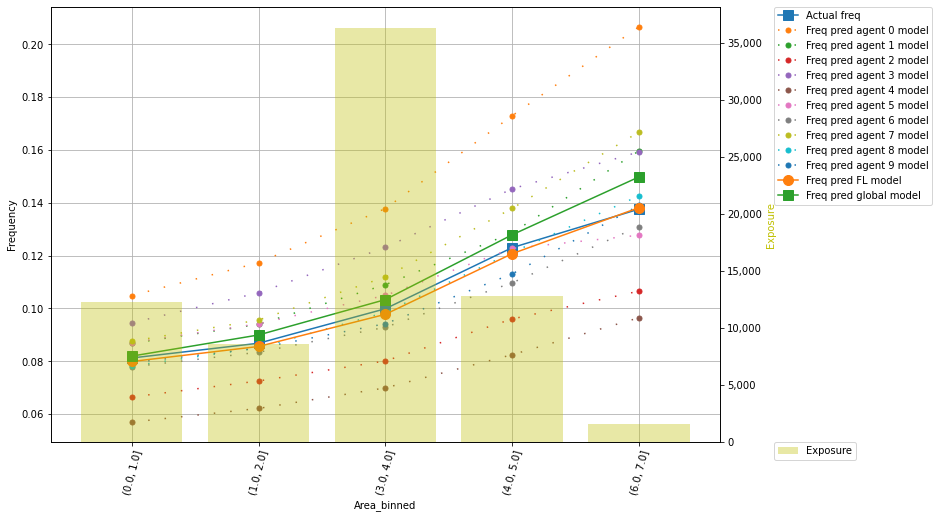

C:\Users\dylan\AppData\Local\Temp\ipykernel_311712\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


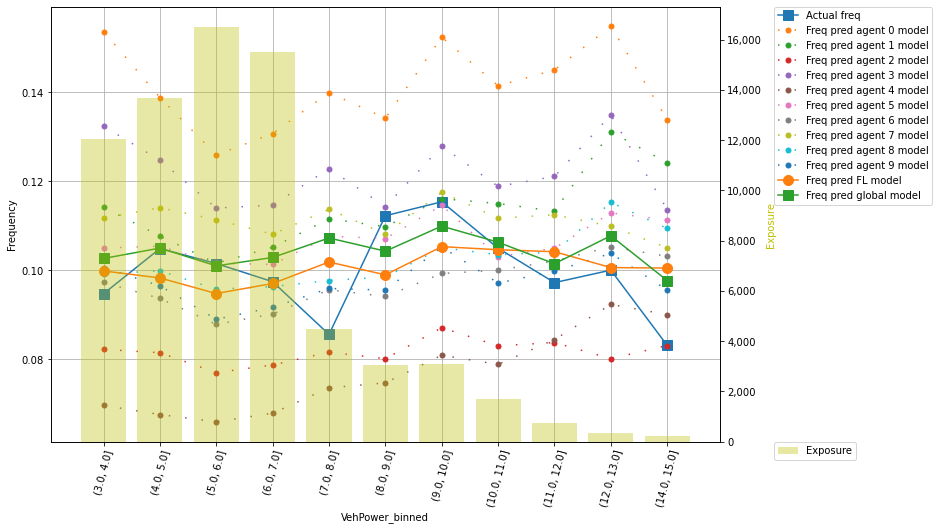

C:\Users\dylan\AppData\Local\Temp\ipykernel_311712\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


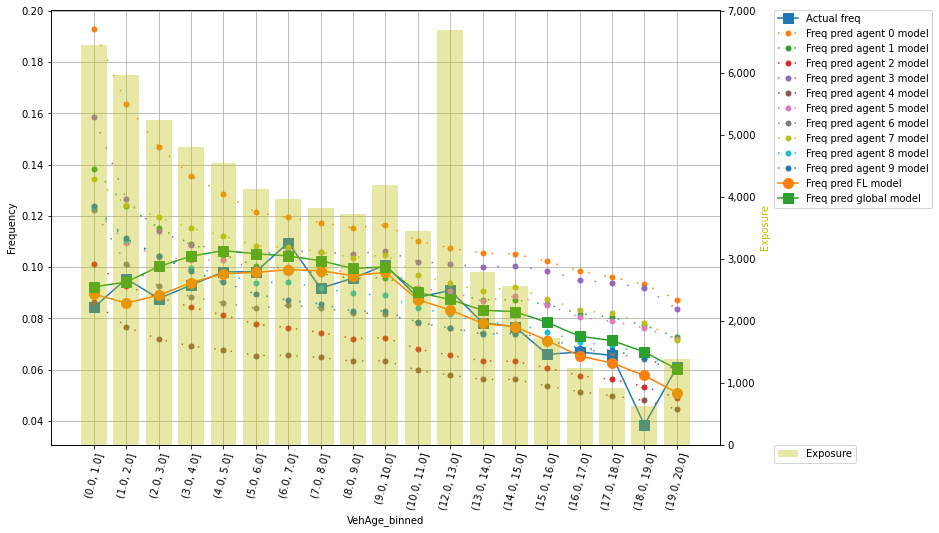

C:\Users\dylan\AppData\Local\Temp\ipykernel_311712\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


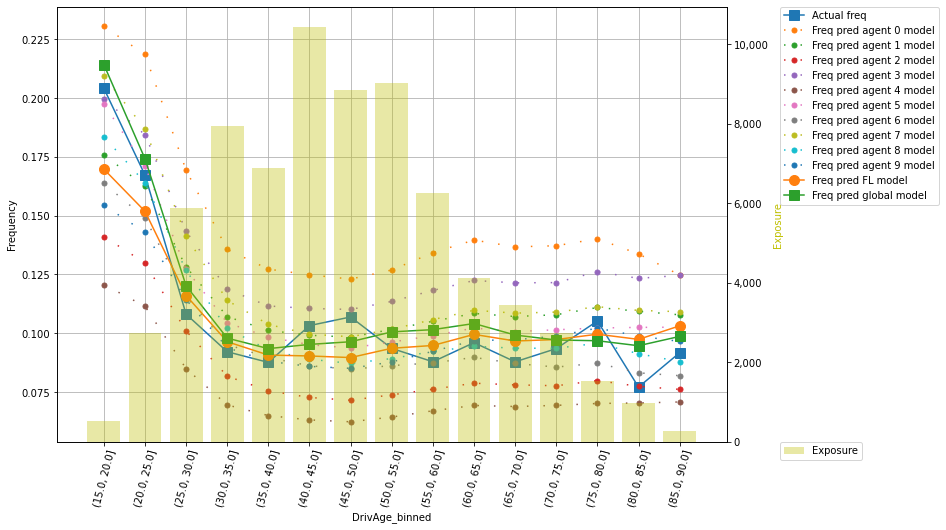

C:\Users\dylan\AppData\Local\Temp\ipykernel_311712\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


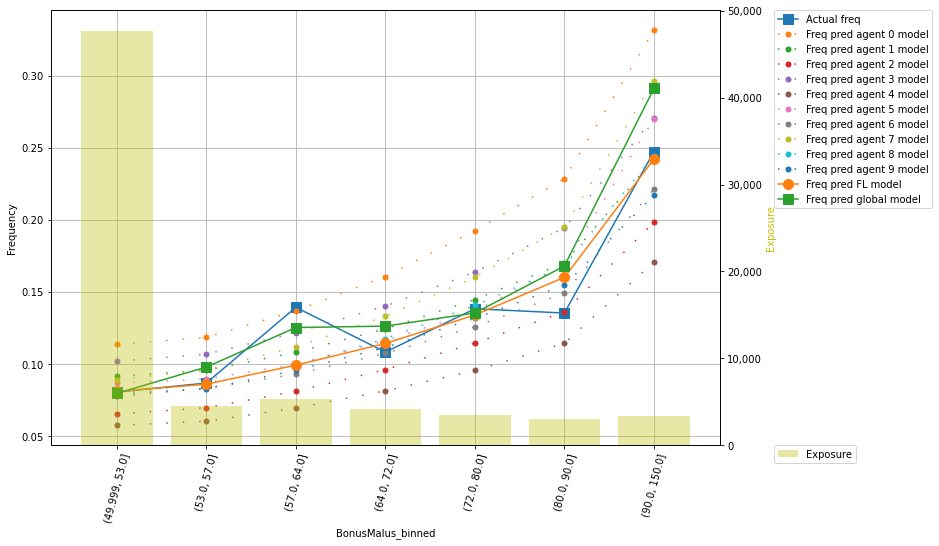

C:\Users\dylan\AppData\Local\Temp\ipykernel_311712\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


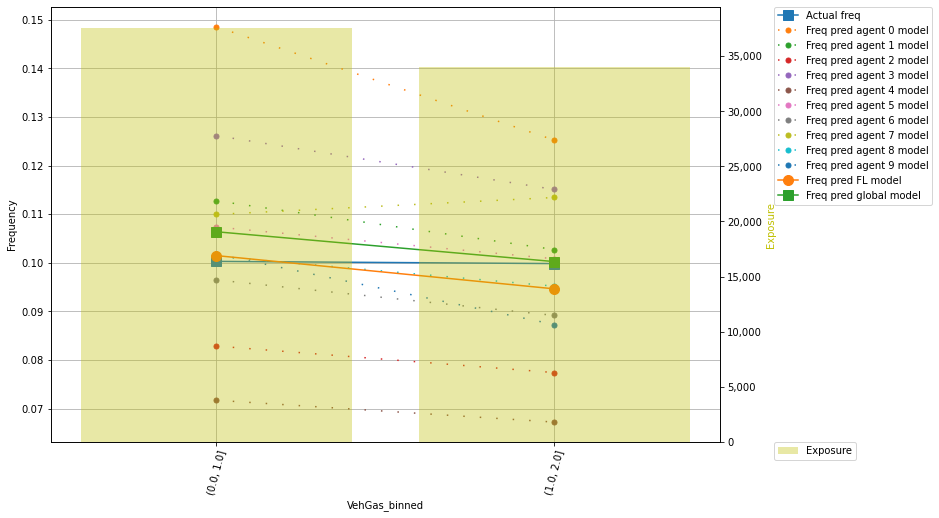

C:\Users\dylan\AppData\Local\Temp\ipykernel_311712\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


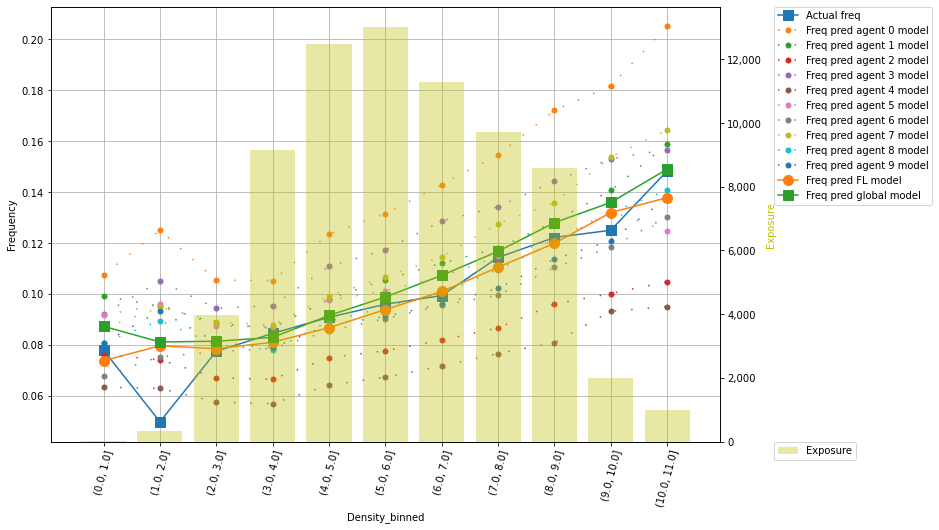

C:\Users\dylan\AppData\Local\Temp\ipykernel_311712\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


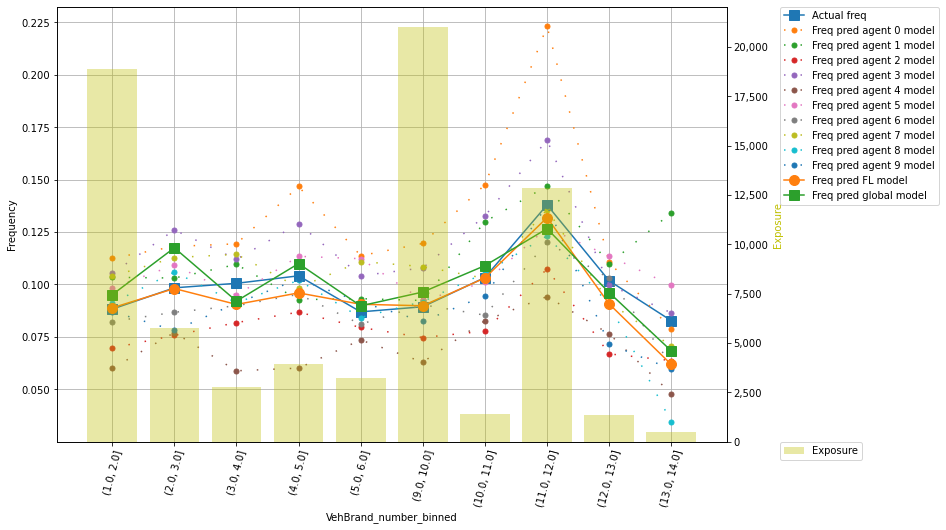

C:\Users\dylan\AppData\Local\Temp\ipykernel_311712\3843640938.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


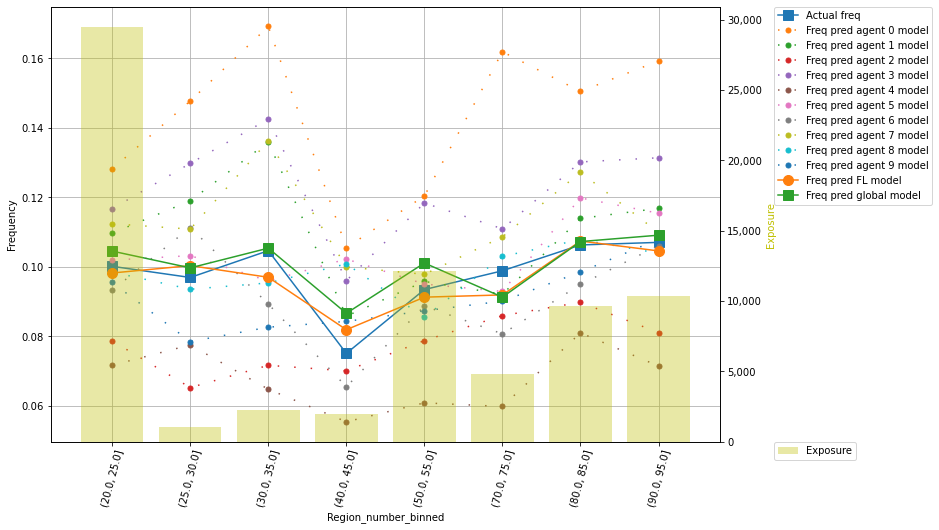

In [29]:
for i in ['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehGas', 'Density', 'VehBrand_number', 'Region_number']:
    one_way_graph_comparison(i, NUM_AGENTS)

# Gini

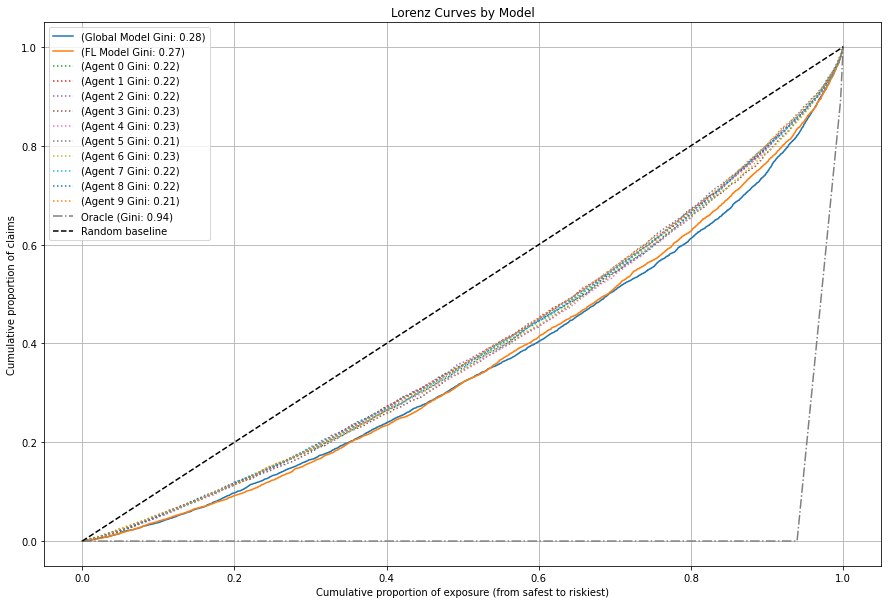

In [30]:
fig, ax = plt.subplots(figsize=(15, 10))

cum_exposure, cum_claims = utils.lorenz_curve(
    df_test_pred['ClaimNb'], df_test_pred['ClaimNb_pred'], df_test_pred["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "(Global Model Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

cum_exposure, cum_claims = utils.lorenz_curve(
    df_test_pred['ClaimNb'], df_test_pred['ClaimNb_fl_pred'], df_test_pred["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "(FL Model Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

for agents in range(NUM_AGENTS):
    cum_exposure, cum_claims = utils.lorenz_curve(
        df_test_pred['ClaimNb'], df_test_pred['ClaimNb_agent_'+str(agents)+'_pred'], df_test_pred["Exposure"]
    )
    gini = 1 - 2 * auc(cum_exposure, cum_claims)
    label = '(Agent {} Gini: {:.2f})'.format(agents, gini)
    plt.plot(cum_exposure, cum_claims, linestyle="dotted", label=label)

# Oracle model: y_pred == y_test
cum_exposure, cum_claims = utils.lorenz_curve(
    df_test_pred['ClaimNb'], df_test_pred['ClaimNb'], df_test_pred["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "Oracle (Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-.", color="gray", label=label)

# Random Baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz Curves by Model",
    xlabel="Cumulative proportion of exposure (from safest to riskiest)",
    ylabel="Cumulative proportion of claims",
)

plt.grid()
ax.legend(loc="upper left")

#plt.savefig(f'../ag_{ag}/' + 'lift_chart')

# Metric comparison

In [31]:
y_fl_pred = df_test['ClaimNb_fl_pred']

In [32]:
fl_weighted_pde = d2_tweedie_score(y_test, y_fl_pred, sample_weight=X_test[:, 0], power=1)
fl_weighted_pde 

0.04798658304504588

In [33]:
y_global_pred = df_test['ClaimNb_pred']
global_weighted_pde = d2_tweedie_score(y_test, y_global_pred, sample_weight=X_test[:, 0], power=1)
global_weighted_pde 

0.050392908409067516

In [34]:
weighted_pde_df = top_results_df[['agent', 'test_weighted_pde']]
weighted_pde_df

,agent,test_weighted_pde
0,-1,0.050393
15,0,0.013170
30,1,0.029827
45,2,0.021838
60,3,0.028905
75,4,0.010571
90,5,0.026741
105,6,0.030654
120,7,0.029881
135,8,0.030875


In [35]:
weighted_pde_df.loc[151] = [-2, d2_tweedie_score(y_test, y_fl_pred, sample_weight=X_test[:, 0], power=1)]
weighted_pde_df

C:\Users\dylan\AppData\Local\Temp\ipykernel_311712\1077199988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_pde_df.loc[151] = [-2, d2_tweedie_score(y_test, y_fl_pred, sample_weight=X_test[:, 0], power=1)]


,agent,test_weighted_pde
0,-1.0,0.050393
15,0.0,0.013170
30,1.0,0.029827
45,2.0,0.021838
60,3.0,0.028905
75,4.0,0.010571
90,5.0,0.026741
105,6.0,0.030654
120,7.0,0.029881
135,8.0,0.030875


In [36]:
weighted_pde_df['fl_relative_increase'] = fl_weighted_pde/weighted_pde_df['test_weighted_pde'] - 1
weighted_pde_df

C:\Users\dylan\AppData\Local\Temp\ipykernel_311712\2142954441.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_pde_df['fl_relative_increase'] = fl_weighted_pde/weighted_pde_df['test_weighted_pde'] - 1


,agent,test_weighted_pde,fl_relative_increase
0,-1.0,0.050393,-0.047751
15,0.0,0.013170,2.643761
30,1.0,0.029827,0.608839
45,2.0,0.021838,1.197366
60,3.0,0.028905,0.660139
75,4.0,0.010571,3.539314
90,5.0,0.026741,0.794477
105,6.0,0.030654,0.565419
120,7.0,0.029881,0.605919
135,8.0,0.030875,0.554226


In [37]:
weighted_pde_df['model'] = 'Agent'+' '+weighted_pde_df['agent'].astype(int).apply(str)
weighted_pde_df

C:\Users\dylan\AppData\Local\Temp\ipykernel_311712\4185987070.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_pde_df['model'] = 'Agent'+' '+weighted_pde_df['agent'].astype(int).apply(str)


,agent,test_weighted_pde,fl_relative_increase,model
0,-1.0,0.050393,-0.047751,Agent -1
15,0.0,0.013170,2.643761,Agent 0
30,1.0,0.029827,0.608839,Agent 1
45,2.0,0.021838,1.197366,Agent 2
60,3.0,0.028905,0.660139,Agent 3
75,4.0,0.010571,3.539314,Agent 4
90,5.0,0.026741,0.794477,Agent 5
105,6.0,0.030654,0.565419,Agent 6
120,7.0,0.029881,0.605919,Agent 7
135,8.0,0.030875,0.554226,Agent 8


In [38]:
weighted_pde_df['model'] = weighted_pde_df['model'].str.replace('Agent -1','Global Model')
weighted_pde_df['model'] = weighted_pde_df['model'].str.replace('Agent -2','Federated Model')
weighted_pde_df

C:\Users\dylan\AppData\Local\Temp\ipykernel_311712\444642117.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_pde_df['model'] = weighted_pde_df['model'].str.replace('Agent -1','Global Model')
C:\Users\dylan\AppData\Local\Temp\ipykernel_311712\444642117.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_pde_df['model'] = weighted_pde_df['model'].str.replace('Agent -2','Federated Model')


,agent,test_weighted_pde,fl_relative_increase,model
0,-1.0,0.050393,-0.047751,Global Model
15,0.0,0.013170,2.643761,Agent 0
30,1.0,0.029827,0.608839,Agent 1
45,2.0,0.021838,1.197366,Agent 2
60,3.0,0.028905,0.660139,Agent 3
75,4.0,0.010571,3.539314,Agent 4
90,5.0,0.026741,0.794477,Agent 5
105,6.0,0.030654,0.565419,Agent 6
120,7.0,0.029881,0.605919,Agent 7
135,8.0,0.030875,0.554226,Agent 8


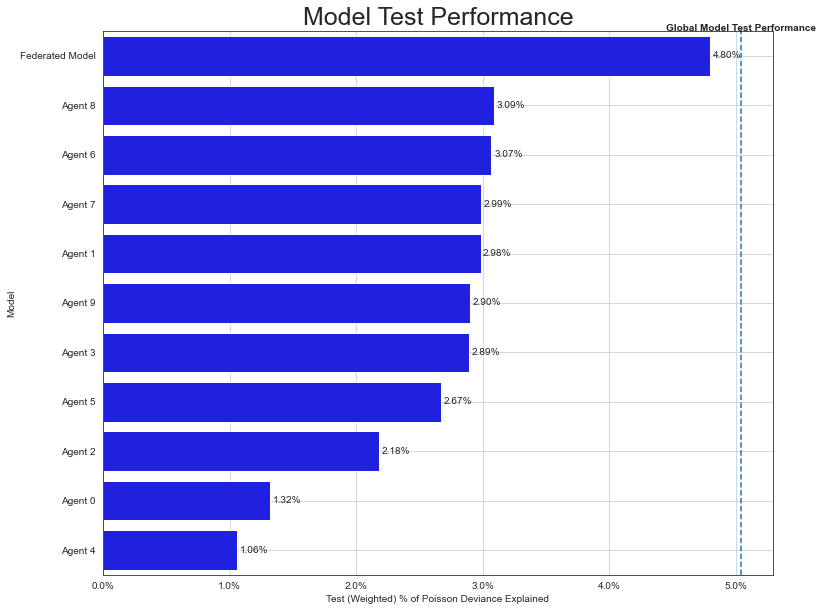

In [49]:
fig, ax = plt.subplots(figsize=(12,10))

sns.set_style('white')

ax=sns.barplot(y='model', 
               x='test_weighted_pde',
               data=weighted_pde_df.iloc[1:,:].sort_values(by=['test_weighted_pde'], ascending = False),
               orient='h',
               color='blue',
               )
plt.title('Model Test Performance', fontsize=25)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Test (Weighted) % of Poisson Deviance Explained', fontsize=10)
plt.ylabel('Model', fontsize=10)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axvline(global_weighted_pde, ls='--')
ax.annotate('Global Model Test Performance', xy=(global_weighted_pde, -0.5), horizontalalignment='center', weight='semibold', size='medium')
for i in range(11):
    ax.text(round(weighted_pde_df.sort_values(by=['test_weighted_pde'], ascending=False).reset_index(drop=True).iloc[1+i:2+i,1],4).tolist()[0]+0.0002, 
            i, 
            '{:.2%}'.format(round(weighted_pde_df.sort_values(by=['test_weighted_pde'], ascending=False).reset_index(drop=True).iloc[1+i:2+i,1],4).tolist()[0]),
            verticalalignment='center',
            fontdict=(dict(fontsize=10)))
ax.grid(True)
plt.show()

In [40]:
'{:.2%}'.format(weighted_pde_df.sort_values(by=['test_weighted_pde'], ascending=False).reset_index(drop=True).iloc[1:2,1].tolist()[0])

'4.80%'

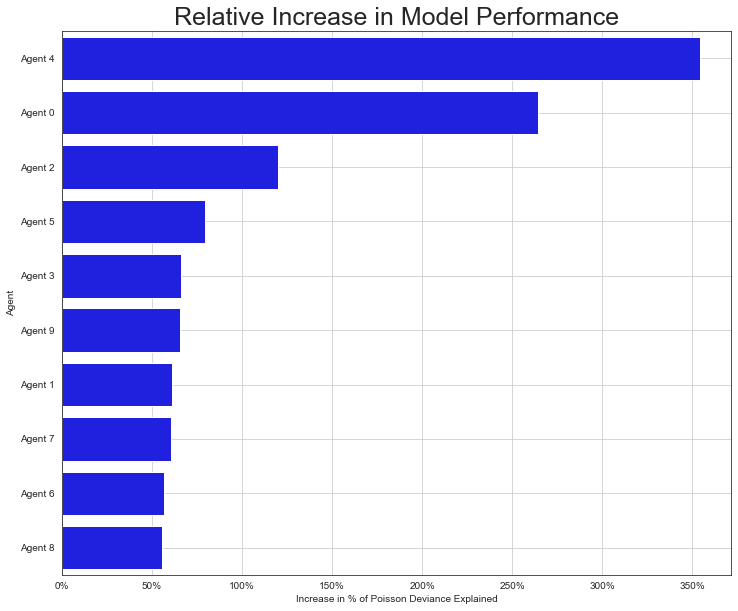

In [41]:
fig, ax = plt.subplots(figsize=(12,10))

sns.set_style('white')

ax=sns.barplot(y='model', 
               x='fl_relative_increase',
               data=weighted_pde_df[~weighted_pde_df.agent.isin([-1, -2])].sort_values(by=['fl_relative_increase'], ascending = False),
               orient='h',
               color='blue',
               )
plt.title('Relative Increase in Model Performance', fontsize=25)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Increase in % of Poisson Deviance Explained', fontsize=10)
plt.ylabel('Agent', fontsize=10)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(True)
plt.show()

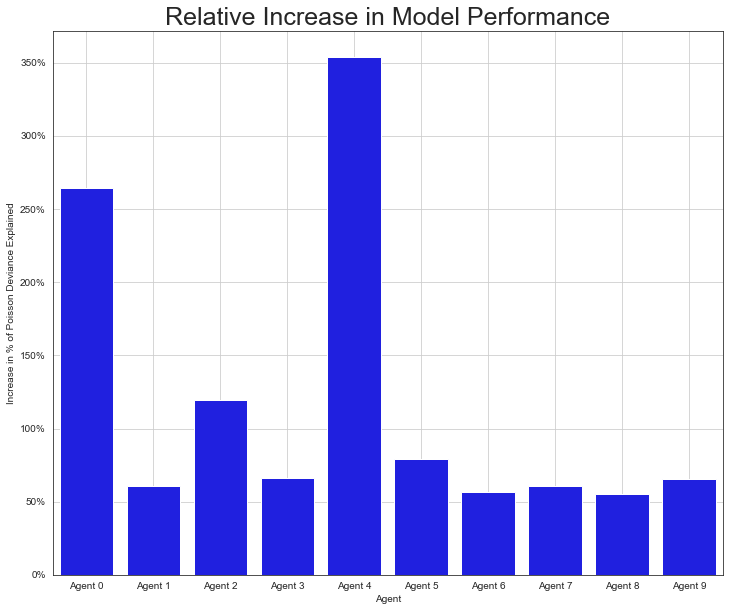

In [42]:
fig, ax = plt.subplots(figsize=(12,10))

sns.set_style('white')

ax=sns.barplot(x='model', 
               y='fl_relative_increase',
               data=weighted_pde_df[~weighted_pde_df.agent.isin([-1, -2])],
               #orient='h',
               color='blue',
               )
plt.title('Relative Increase in Model Performance', fontsize=25)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Increase in % of Poisson Deviance Explained', fontsize=10)
plt.xlabel('Agent', fontsize=10)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(True)
plt.show()

In [43]:
import csv
import json

In [44]:
def read_csv(filename):
    loss_stats_dict = dict()
    with open(filename) as f:
        file_data=csv.reader(f)
        headers=next(file_data)
        round = 0
        for i in file_data:
            loss_stats_dict[round] = dict(zip(headers,i))
            round +=1
    return loss_stats_dict

In [45]:
loss_stats = dict()
for ag_id in range(-1, NUM_AGENTS):
    if ag_id == -1:
        MY_DATA_PATH = '../../../3agents/IFoA-FL-WP/ag_global'
    else:    
        MY_DATA_PATH = '../../../3agents/IFoA-FL-WP/ag_' + str(ag_id)
    
    loss_stats[ag_id] = read_csv(MY_DATA_PATH + '/los_stats.csv')

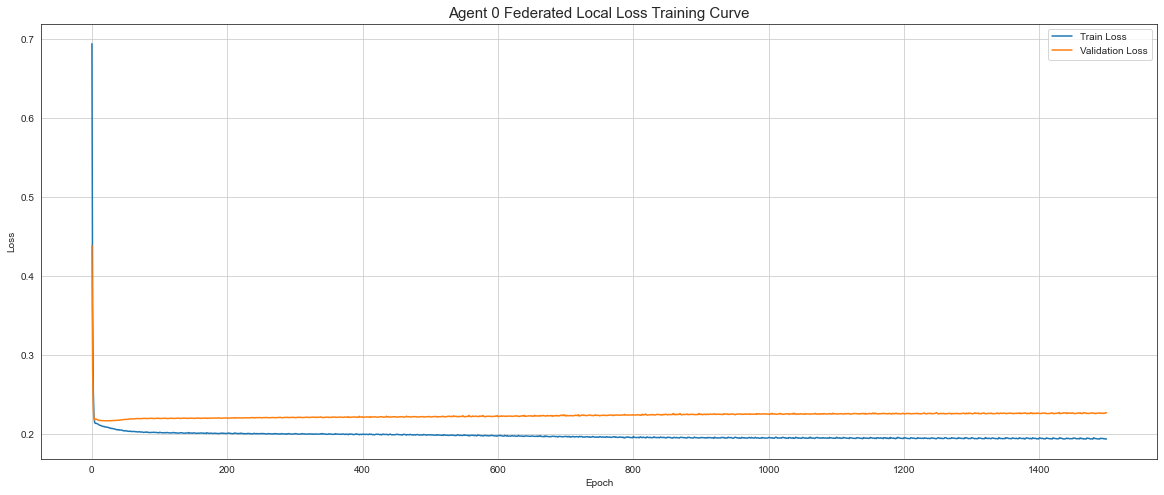

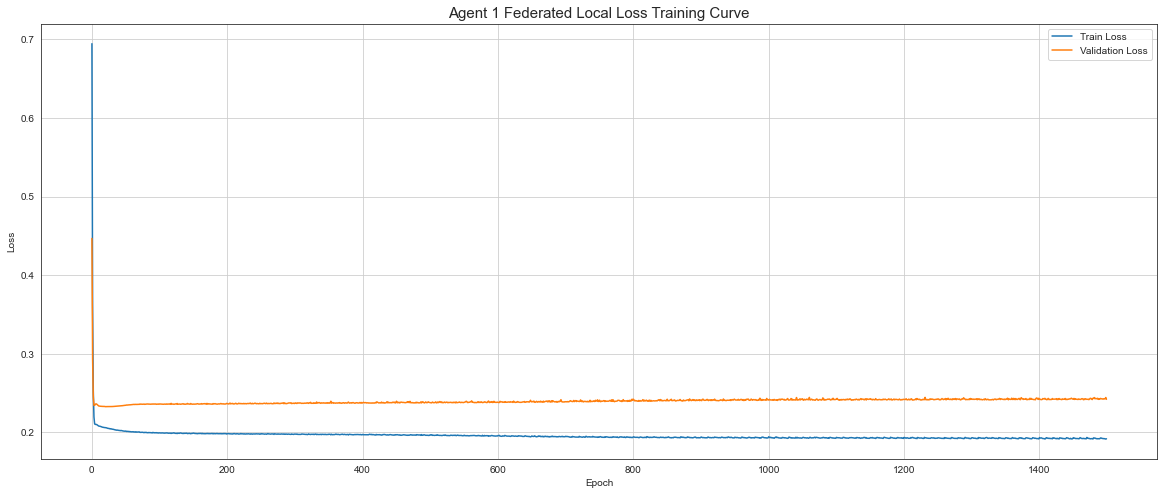

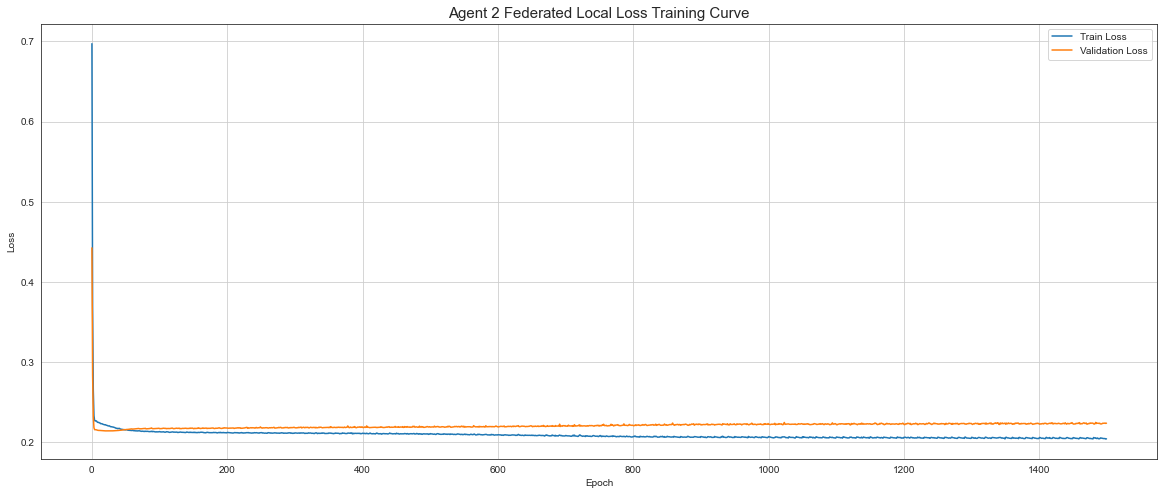

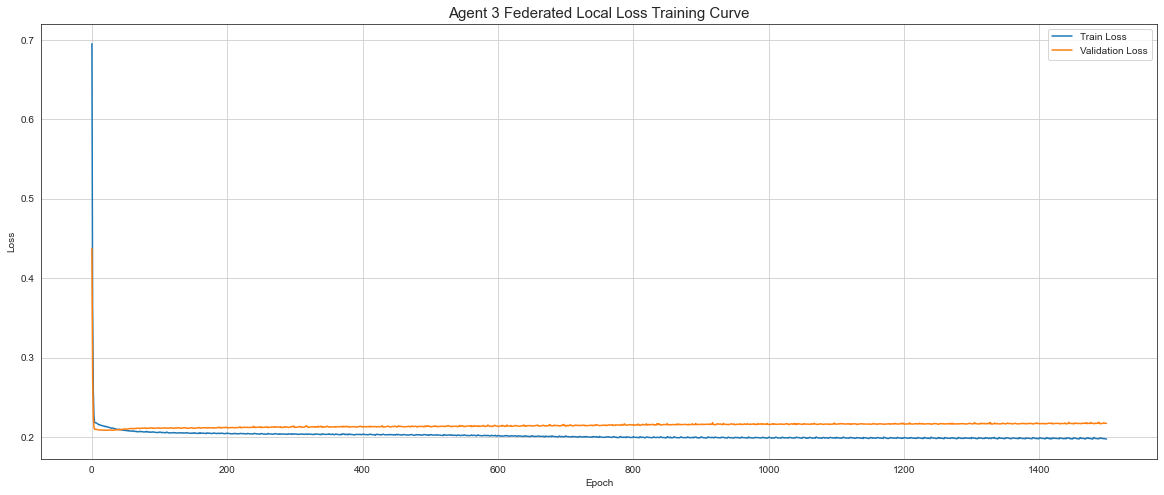

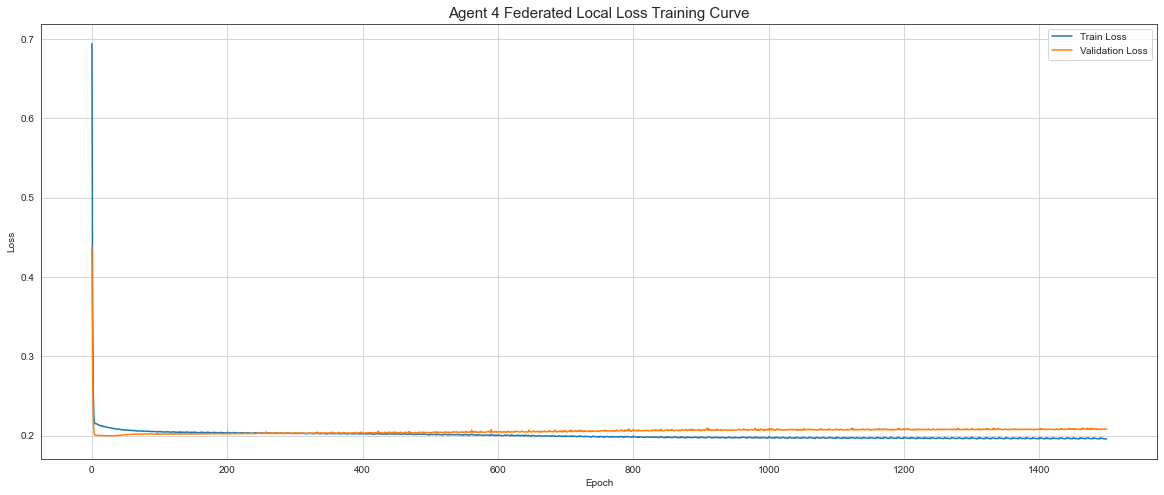

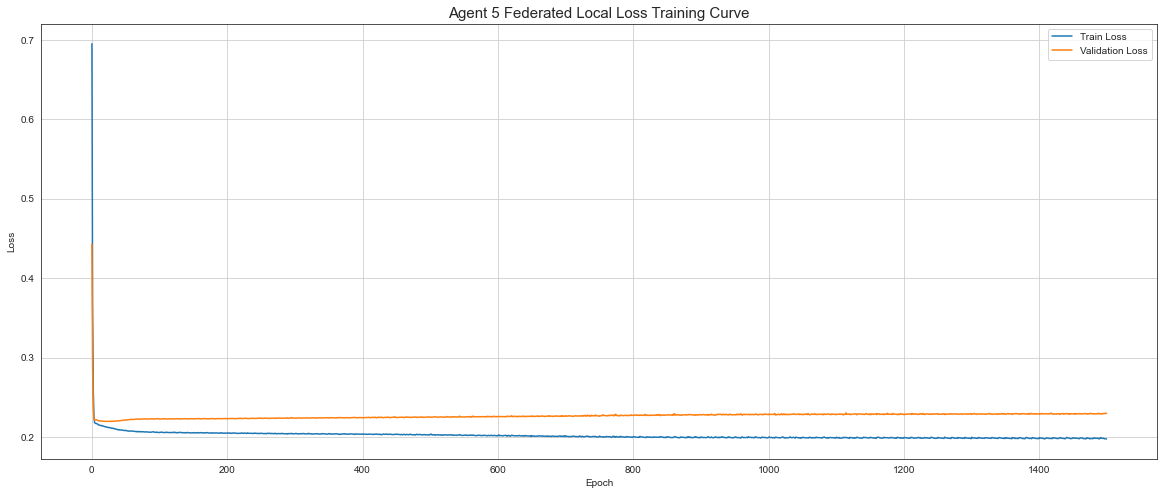

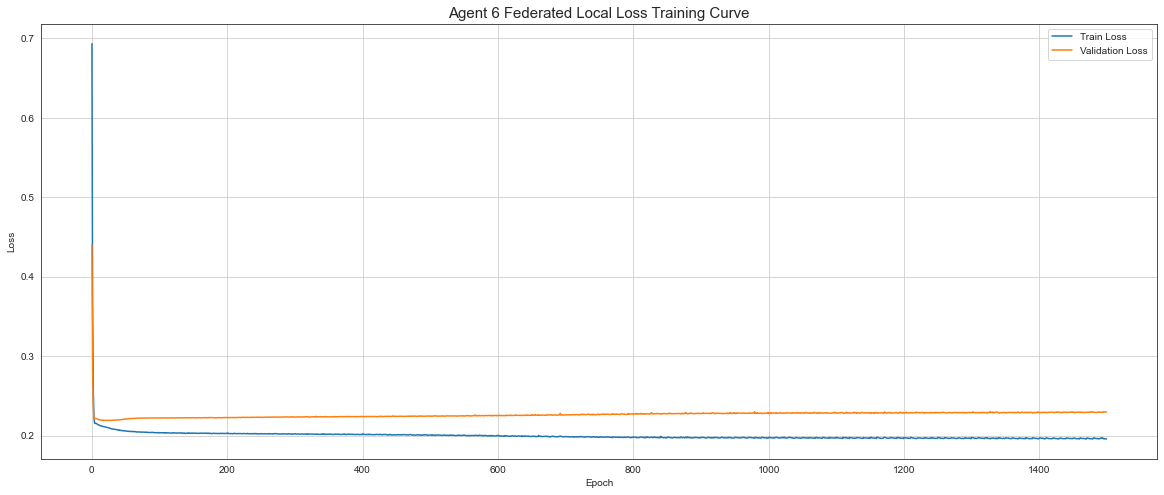

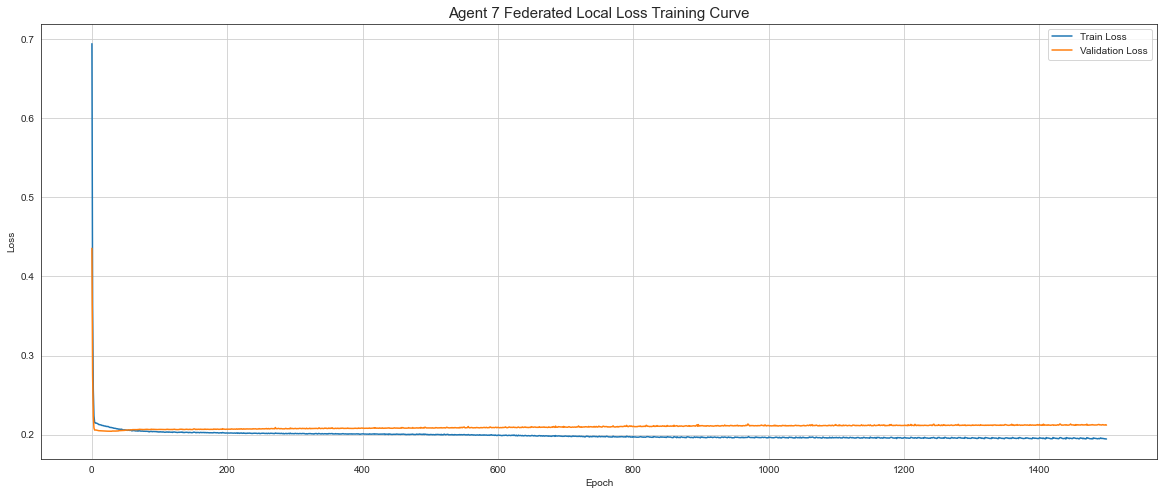

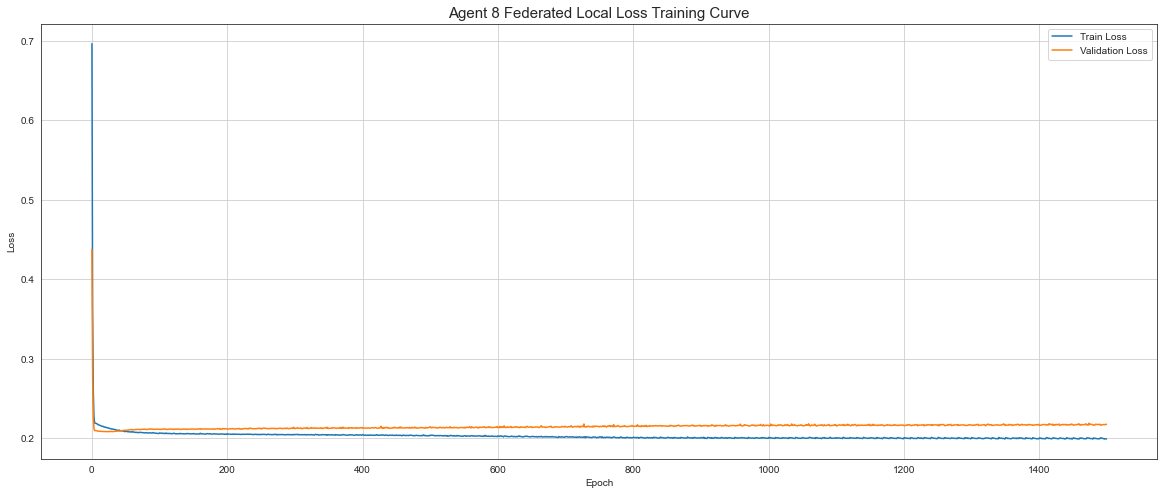

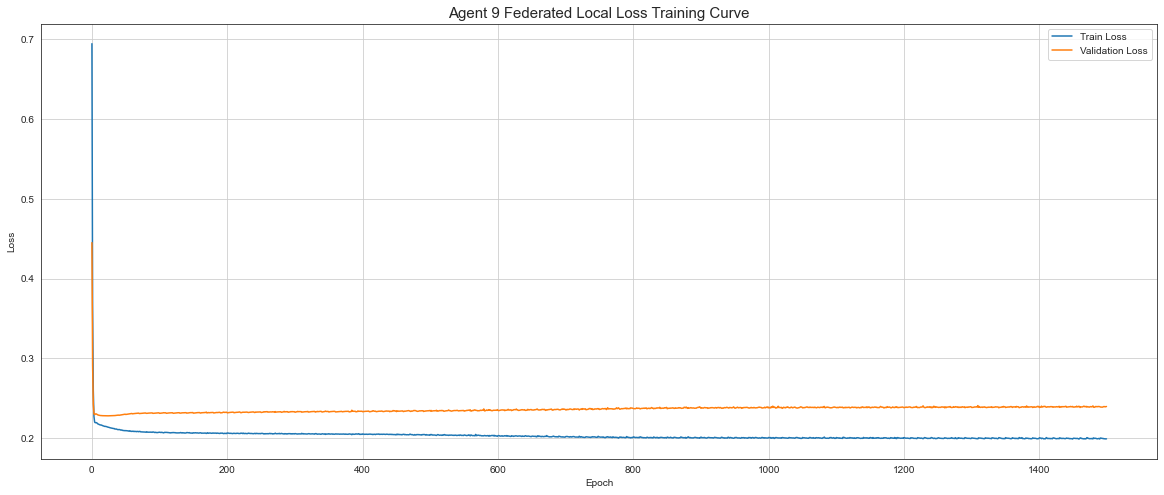

In [46]:
for ag in range(0,10):
    loss_train_list = []
    loss_val_list = []
    for rnd_no in range(0, NUM_ROUNDS*2 +1):
                    if rnd_no % 2 != 0: # FIXED : TO_FIX !!!!!!!!    MS: -1 added temporarly!!!! I need to find out why some clients join from 2nd round ( ask Malgorzata if that is not clear :) 
                        y_train_loss = json.loads(loss_stats[ag][rnd_no]["train"])
                        loss_train_list.extend(y_train_loss)
                        y_val_loss = json.loads(loss_stats[ag][rnd_no]["val"])
                        loss_val_list.extend(y_val_loss)
    plt.figure(figsize=(20,8))
    plt.plot(loss_train_list[:], label='Train Loss')
    plt.plot(loss_val_list[:], label='Validation Loss')
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.title(f'Agent {ag} Federated Local Loss Training Curve', fontsize=15)
    plt.legend()
    plt.grid()
    plt.show()